# Inverse transformations and test-time augmentations

This notebook demonstrates the use of invertible transforms. Later in the notebook, we also look at performing the inverse transformations on a batch of data, and then leveraging inverse transformations to perform test-time augmentations.


### What are transforms?

- We use transforms to modify data. In MONAI, we use them to (for exampl) load images from file, add a channel component, normalise the intensities and reshape the image.
- We can also use transforms as a method of data augmentation – we have a finite amount of data so to avoid overfitting, we can apply random transforms to modify our data each epoch.
- Examples of random transformations might be randomly flipping, rotating, cropping, padding, zooming, as well as applying non-rigid deformations.


### Inverse transforms

- Having applied transformations (random or not) to our data, it can often be useful to return them to their original space after. You might, for example, want to use a network to segment an image, and then you'll want that segmented image in the same space as the input so that you can compare them. You could then save them to file and compare them in your favourite medical image viewer.
- In MONAI, the majority of our spatial transforms are invertible. You can double check with `isinstance(x, InvertibleTransform)`.

### Test-time augmentations

- If your network includes random transformations, you may want to observe the effect that these transformations have on the output.
- To do this, you could pass the same input through the network multiple times, using different random realisations. You could then use the inverse transforms to move all the results to a common space, and you could then calculate the metrics.
- This is the purpose of MONAI's `TestTimeAugmentation`, which by default will calculate the mode, mean, standard deviation and volume variation coefficient. For more information on this, see https://doi.org/10.1016/j.neucom.2019.01.103.

### This notebook

For the sake of speed, we'll use a 2D dataset here, although needless to say the workflow would be identical for 3D data.

We'll generate the data by taking Decathlon's 3D brain tumor dataset, taking the 2D slice containing the most voxels > 0 (the most label), and then saving the new dataset to disk.

After that, we'll do normal 2D training with a few augmentations, which means that we'll be able to benefit from the inverse transformations.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/inverse_transforms_and_test_time_augmentations.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
from functools import partial
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random
import tempfile
import torch
from tqdm import tqdm

import monai
from monai.apps import download_and_extract
from monai.data import (
    BatchInverseTransform,
    CacheDataset,
    DataLoader,
    Dataset,
    pad_list_data_collate,
    TestTimeAugmentation,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks import eval_mode
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    DivisiblePadd,
    KeepLargestConnectedComponent,
    Lambdad,
    LoadImaged,
    MapTransform,
    RandAffined,
    ScaleIntensityd,
    ToTensord,
)
from monai.transforms.utils import allow_missing_keys_mode
from monai.utils import first, set_determinism

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.5.0rc3+1.g0813ae5
Numpy version: 1.20.2
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 0813ae5fb2488f1407d98bc3e32a8c4e3c931524

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.2
Tensorboard version: 2.4.1
gdown version: 3.12.2
TorchVision version: 0.9.1+cu102
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.1.1
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/home/rbrown/data/MONAI


## Create data

Get data, get 2D slice with most voxels > 0 (most label) and save.

In [4]:
task = "Task01_BrainTumour"
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/" + task + ".tar"

compressed_file = os.path.join(root_dir, task + ".tar")
data_dir = os.path.join(root_dir, task)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

images = sorted(glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
labels = sorted(glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image, "label": label}
              for image, label in zip(images, labels)]

In [5]:
class SliceWithMaxNumLabelsd(MapTransform):
    def __init__(self, keys, label_key):
        self.keys = keys
        self.label_key = label_key

    def __call__(self, data):
        d = dict(data)
        im = d[self.label_key]
        q = np.sum((im > 0).reshape(-1, im.shape[-1]), axis=0)
        _slice = np.where(q == np.max(q))[0][0]
        for key in self.keys:
            d[key] = d[key][..., _slice]
        return d


class SaveSliced(MapTransform):
    def __init__(self, keys, path):
        self.keys = keys
        self.path = path

    def __call__(self, data):
        d = {}
        for key in self.keys:
            fname = os.path.basename(
                data[key + "_meta_dict"]["filename_or_obj"])
            path = os.path.join(self.path, key, fname)
            nib.save(nib.Nifti1Image(data[key], np.eye(4)), path)
            d[key] = path
        return d


keys = ["image", "label"]
data_dir = os.path.join(root_dir, task + "_single_slice")
for key in keys:
    os.makedirs(os.path.join(data_dir, key), exist_ok=True)
transform_2d_slice = Compose([
    LoadImaged(keys),
    AsChannelFirstd("image"),
    AddChanneld("label"),
    SliceWithMaxNumLabelsd(keys, "label"),
    SaveSliced(keys, data_dir),
])
# Running the whole way through the dataset will create the 2D slices and save to file
ds_2d = Dataset(data_dicts, transform_2d_slice)
dl_2d = DataLoader(ds_2d, batch_size=1, num_workers=10)
data_dicts_single_slice = list(tqdm(dl_2d))

100%|██████████| 484/484 [00:47<00:00, 10.28it/s]


In [6]:
random.shuffle(data_dicts_single_slice)
num_files = len(data_dicts_single_slice)
num_train_files = round(0.8 * num_files)
train_files = data_dicts_single_slice[:num_train_files]
val_files = data_dicts_single_slice[num_train_files:]
print("total num files:", len(data_dicts_single_slice))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

total num files: 484
num training files: 387
num validation files: 97


In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys),
        Lambdad("label", lambda x: (x > 0).astype(
            np.float64)),  # make label binary
        RandAffined(
            keys,
            prob=1.0,
            spatial_size=(300, 300),
            rotate_range=(np.pi / 3, np.pi / 3),
            translate_range=(3, 3),
            scale_range=((0.8, 1), (0.8, 1)),
            padding_mode="zeros",
            mode=("bilinear", "nearest"),
            as_tensor_output=False,
        ),
        CropForegroundd(keys, source_key="image"),
        DivisiblePadd(keys, 16),
        ScaleIntensityd("image"),
        ToTensord(keys),
    ]
)
val_transforms = train_transforms

In [8]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2,
                          num_workers=10, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1,
                        num_workers=10, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 97/97 [00:00<00:00, 191.66it/s]


## Display some examples

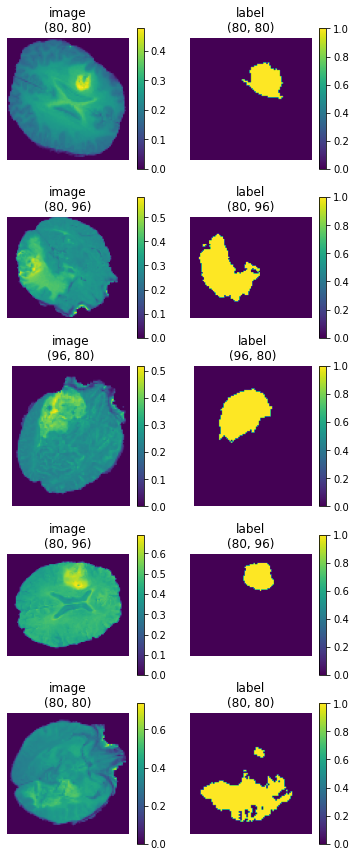

In [9]:
%matplotlib inline
def imshows(ims):
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            im = np.mean(im, axis=0)  # average across channels
            if len(ims) == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")
            fig.colorbar(im_show, ax=ax)


to_imshow = []
for file in np.random.choice(train_files, size=5, replace=False):
    data = train_transforms(file)
    to_imshow.append({"image": data["image"], "label": data["label"]})
imshows(to_imshow)

In [10]:
# Function for live plotting whilst running training
def plot_range(data, wrapped_generator):
    # Get ax, show plot, etc.
    plt.ion()
    for d in data.values():
        ax = d["line"].axes
    fig = ax.get_figure()
    fig.show()

    for i in wrapped_generator:
        yield i
        # update plots, legend, view
        for d in data.values():
            d["line"].set_data(d["x"], d["y"])
        ax.legend()
        ax.relim()
        ax.autoscale_view()
        fig.canvas.draw()

In [11]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold_values=True),
    KeepLargestConnectedComponent(applied_labels=1),
])


def infer_seg(images, model, roi_size=(96, 96), sw_batch_size=4):
    val_outputs = sliding_window_inference(
        images, roi_size, sw_batch_size, model)
    return post_trans(val_outputs)


# Create network, loss fn., etc.
dice_metric = DiceMetric(include_background=True, reduction="mean")
in_channels = train_ds[0]["image"].shape[0]
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=in_channels,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

<IPython.core.display.Javascript object>


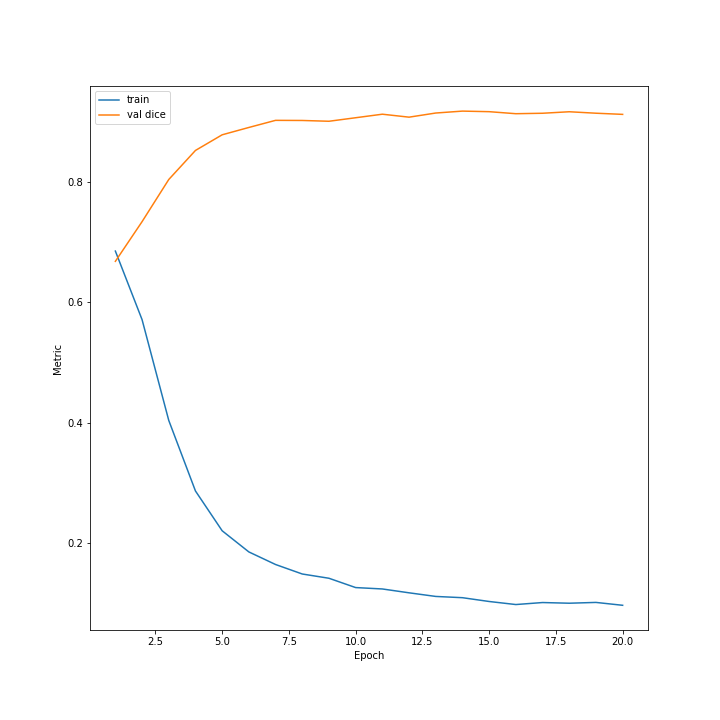

train completed, best_metric: 0.9174 at epoch: 14


In [12]:
%matplotlib notebook

best_model_path = "best_model_inverse_transforms.pth"
skip_training_if_poss = True
skip_training = skip_training_if_poss and os.path.isfile(best_model_path)

if not skip_training:
    # Plotting stuff
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor="white")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric")

    data = {}
    for i in ["train", "val dice"]:
        data[i] = {"x": [], "y": []}
        (data[i]["line"],) = ax.plot(data[i]["x"], data[i]["y"], label=i)

    # start a typical PyTorch training
    max_epochs = 20
    val_interval = 1
    best_metric = -1
    best_metric_epoch = -1

    for epoch in plot_range(data, range(max_epochs)):
        model.train()
        epoch_loss = 0

        for batch_data in train_loader:
            inputs, labels = batch_data["image"].to(
                device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        data["train"]["x"].append(epoch + 1)
        data["train"]["y"].append(epoch_loss)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(model):
                metric_sum = 0.0
                metric_count = 0
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data["image"].to(
                        device), val_data["label"].to(device)
                    val_outputs = infer_seg(val_images, model)
                    value, _ = dice_metric(y_pred=val_outputs, y=val_labels)
                    metric_count += len(value)
                    metric_sum += value.item() * len(value)
                metric = metric_sum / metric_count
                data["val dice"]["x"].append(epoch + 1)
                data["val dice"]["y"].append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), best_model_path)

    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [13]:
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

## Check segmentations

Load validation files, apply validation transforms and display (no inverses yet!).

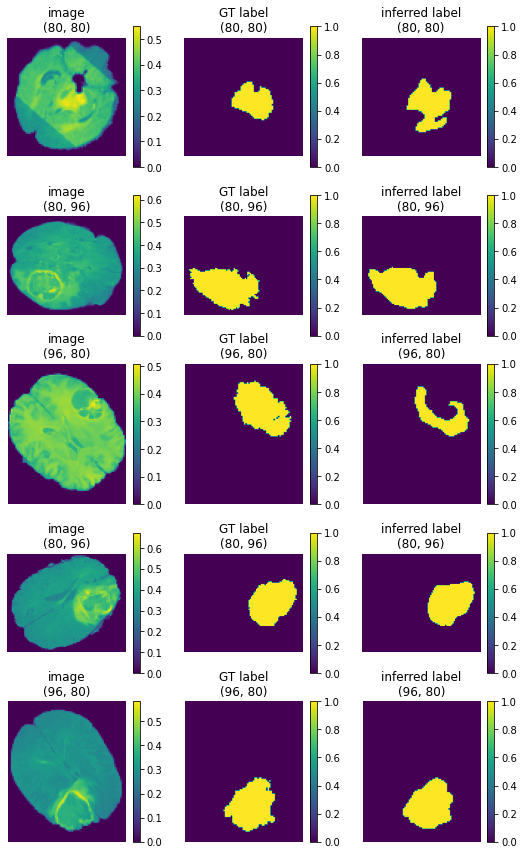

In [14]:
%matplotlib inline
to_imshow = []
for file in np.random.choice(val_files, size=5, replace=False):
    data = val_transforms(file)
    inferred = infer_seg(data["image"][None].to(device), model)[0]
    to_imshow.append({
        "image": data["image"],
        "GT label": data["label"],
        "inferred label": inferred,
    })
imshows(to_imshow)

## Inverse transformation

Here, we want to perform the inverse on a segmented volume. The transformations that we want to inverse were those that were applied to `label`, which are stored under the key `label_transforms`. So we create a new dictionary, with `label` equal to our inferred segmented volume.

When calling the inverse, we use `with allow_missing_keys_mode`, as the transforms were set up with `keys=["image", "label"]` and we only want to perform the inverse on `label`.

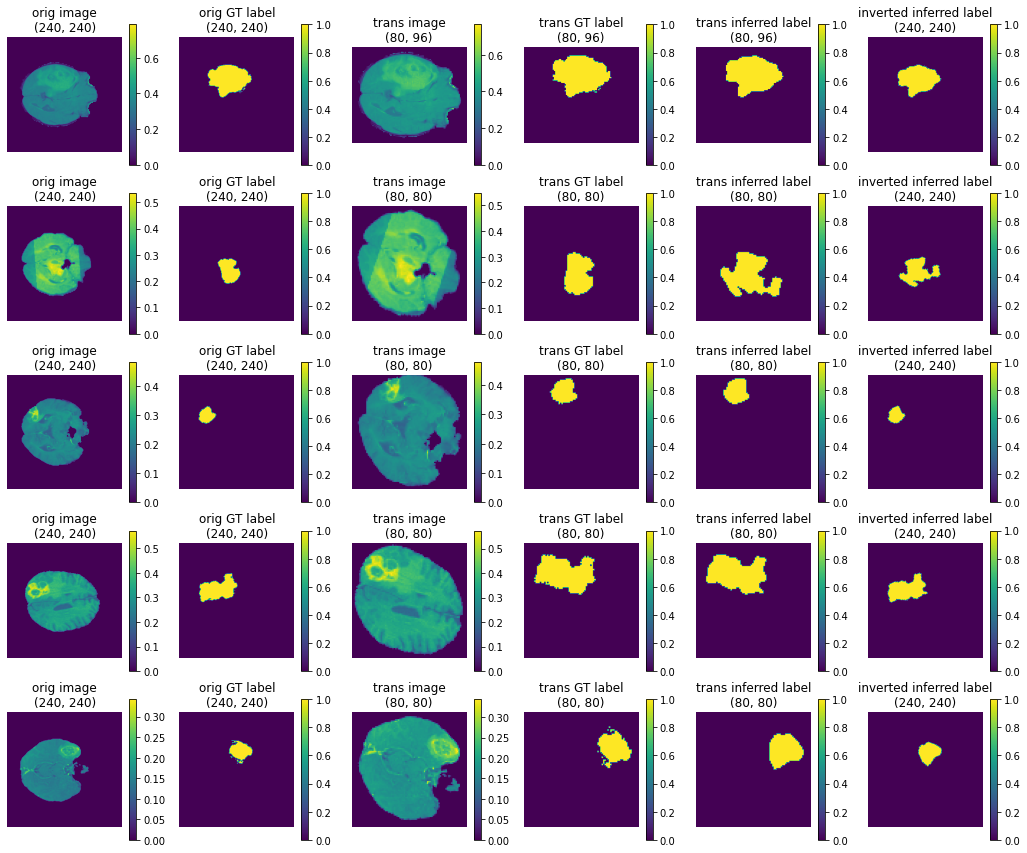

In [15]:
%matplotlib inline

# Need minimal transforms just to be able to show the unmodified originals
minimal_transforms = Compose([
    LoadImaged(keys),
    Lambdad("label", lambda x: (x > 0).astype(
        np.float64)),  # make label binary
    ScaleIntensityd("image"),
    ToTensord(keys),
])

to_imshow = []
for file in np.random.choice(val_files, size=5, replace=False):
    unmodified_data = minimal_transforms(file)
    transformed_data = val_transforms(file)
    seg = infer_seg(transformed_data["image"][None].to(
        device), model).detach().cpu()[0]
    seg_dict = {"label": seg,
                "label_transforms": transformed_data["label_transforms"]}
    with allow_missing_keys_mode(val_transforms):
        inverted_seg = val_transforms.inverse(seg_dict)
    to_imshow.append({
        "orig image": unmodified_data["image"],
        "orig GT label": unmodified_data["label"],
        "trans image": transformed_data["image"],
        "trans GT label": transformed_data["label"],
        "trans inferred label": seg,
        "inverted inferred label": inverted_seg["label"],
    })
imshows(to_imshow)

## Batch inverse

Same as above, except this time we have a whole batch of data, and we invert it with `BatchInverseTransform`.

In [16]:
val_loader = DataLoader(val_ds, batch_size=5, num_workers=0,
                        collate_fn=pad_list_data_collate)
batch_val = first(val_loader)
batch_infer = infer_seg(batch_val["image"].to(device), model).detach().cpu()
batch_inverter = BatchInverseTransform(val_transforms, val_loader)
segs_dict = {"label": batch_infer,
             "label_transforms": batch_val["label_transforms"]}
with allow_missing_keys_mode(val_transforms):
    fwd_bck_batch_labels = batch_inverter(segs_dict)

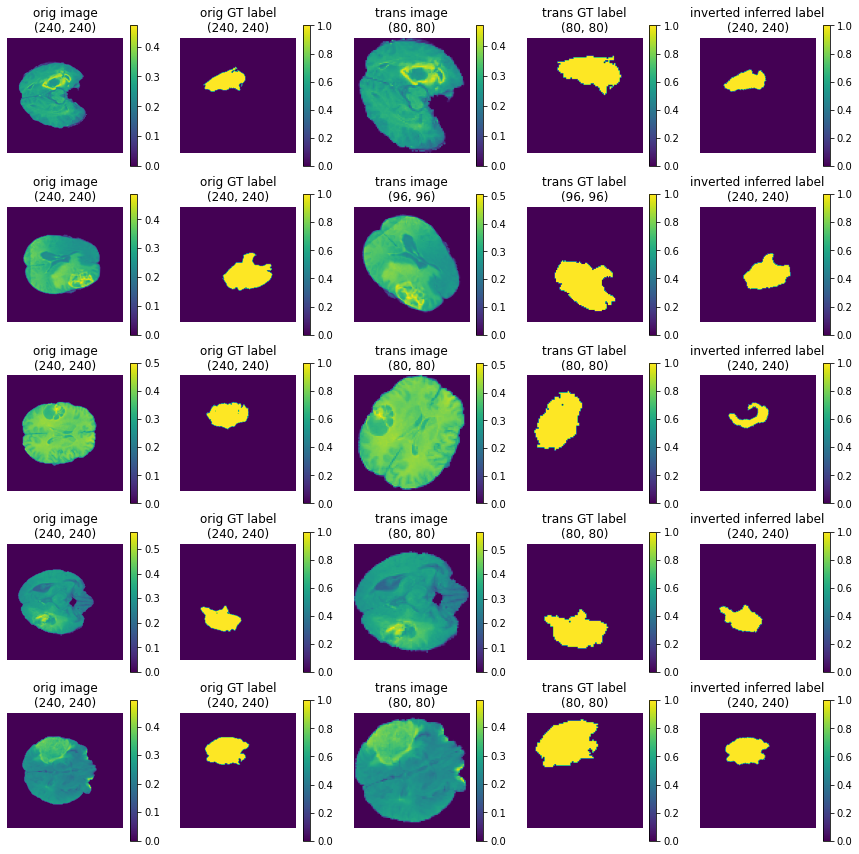

In [17]:
# visualise it
batch_val["label_meta_dict"]["filename_or_obj"]
to_imshow = []
for idx, inverted_seg in enumerate(fwd_bck_batch_labels):
    file = {
        "image": batch_val["image_meta_dict"]["filename_or_obj"][idx],
        "label": batch_val["label_meta_dict"]["filename_or_obj"][idx]
    }
    unmodified_data = minimal_transforms(file)
    transformed_data = val_transforms(file)

    to_imshow.append({
        "orig image": unmodified_data["image"],
        "orig GT label": unmodified_data["label"],
        "trans image": transformed_data["image"],
        "trans GT label": transformed_data["label"],
        "inverted inferred label": inverted_seg["label"],
    })
imshows(to_imshow)

## Test-time augmentations

For the test-time augmentations, we need to tell it which transformations to apply (`val_transforms`), as well as how to extract the output (infer the segmentations).

We then parameterise `num_examples`, and the network will be called this number of times, resulting in segmentations that are different due to differences caused by random transformations. The inverse is applied to each segmentation, and the results averaged.

The mode, mean, standard deviation and volume variation coefficient are returned.

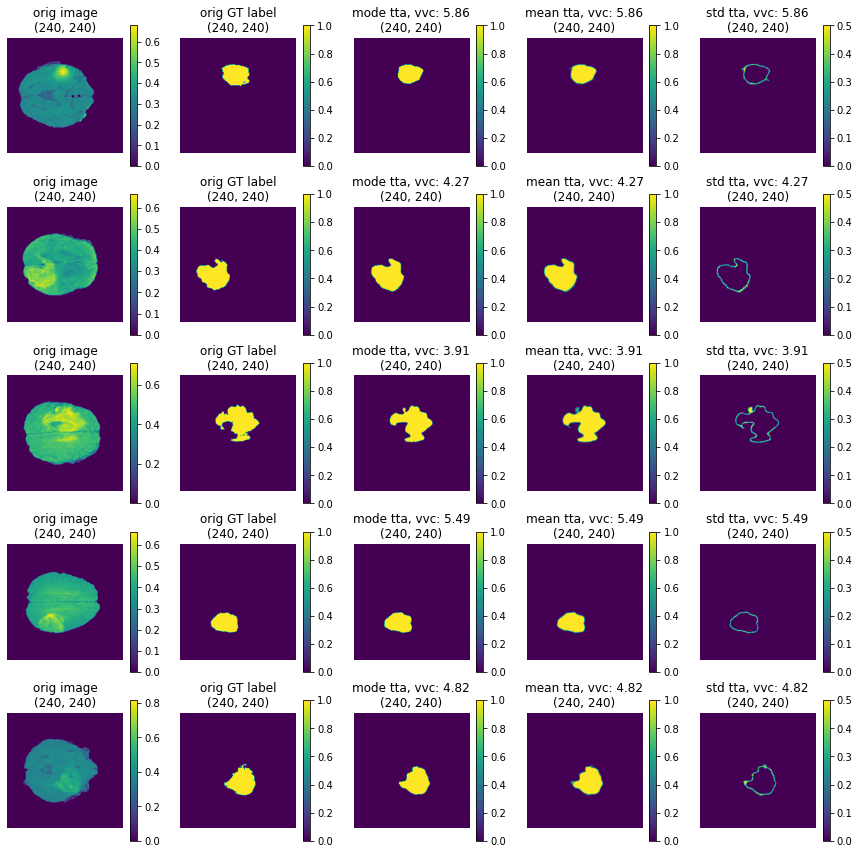

In [18]:
tt_aug = TestTimeAugmentation(
    val_transforms,
    batch_size=5,
    num_workers=0,
    inferrer_fn=partial(infer_seg, model=model),  # fn to infer segmentation
    device=device
)

to_imshow = []

# Get images
for file in np.random.choice(val_files, size=5, replace=False):

    mode_tta, mean_tta, std_tta, vvc_tta = tt_aug(file, num_examples=10)
    unmodified_data = minimal_transforms(file)

    to_imshow.append({
        "orig image": unmodified_data["image"],
        "orig GT label": unmodified_data["label"],
        "mode tta, vvc: %.2f" % vvc_tta: mode_tta,
        "mean tta, vvc: %.2f" % vvc_tta: mean_tta,
        "std tta, vvc: %.2f" % vvc_tta: std_tta,
    })
imshows(to_imshow)